# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [4]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/archivist/sparqlnotebook/network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [5]:
## define SPARQL enpoint
endpoint = "https://ag1mdzaeq7qnj00h.allegrograph.cloud/repositories/archivist"

In [10]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/mroylem/archivist/blob/main/Wikidata/graph/imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [11]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


0
[]


## Inspect the data


In [31]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


ValueError: Length mismatch: Expected axis has 0 elements, new values have 8 elements

### Distribution of relationships in relation to birthYears of organisations members

In [ ]:
l_50 = list(range(1761, 2051, 30))
print(l_50)

In [ ]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [ ]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [ ]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [ ]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

#### Reload from CSV

This is only possible if you already stored the data into a CSV, cf. below

In [9]:
### load from CSV

file_add = 'data/persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

78224


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,membership,http://www.wikidata.org/entity/Q833738,Heidelberg Academy for Sciences and Humanities,2,academy of sciences | building,1911-1940,"['academy of sciences', 'building']"
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,comprehensive university | open-access publish...,1911-1940,"['comprehensive university', 'open-access publ..."


In [10]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1751-1810     2712
1811-1850     3445
1851-1880     5186
1881-1910    10724
1911-1940    24031
1941-1970    25712
1971-2000     6414
dtype: int64


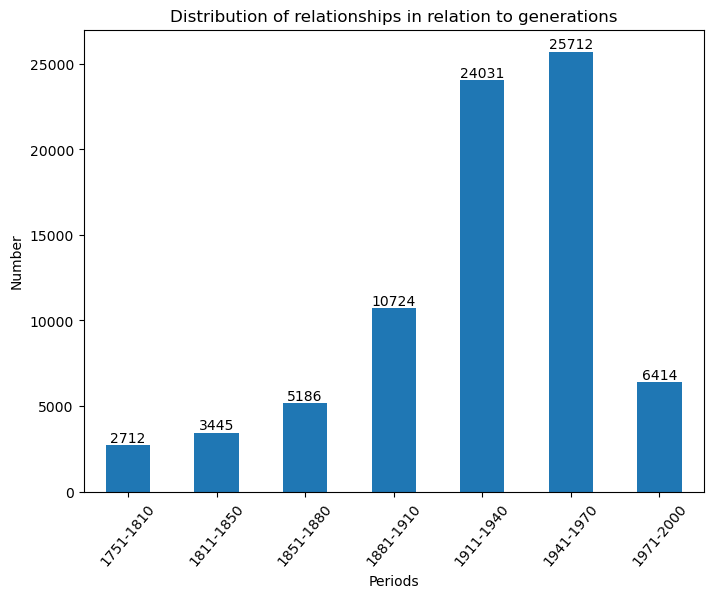

In [11]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [12]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     29294
employment    31537
membership    17393
dtype: int64


In [13]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

      periods    relaType   size
0   1751-1810   education    657
1   1751-1810  employment    627
2   1751-1810  membership   1428
3   1811-1850   education   1037
4   1811-1850  employment    948
5   1811-1850  membership   1460
6   1851-1880   education   1900
7   1851-1880  employment   1758
8   1851-1880  membership   1528
9   1881-1910   education   3928
10  1881-1910  employment   4171
11  1881-1910  membership   2625
12  1911-1940   education   9329
13  1911-1940  employment   9373
14  1911-1940  membership   5329
15  1941-1970   education   9906
16  1941-1970  employment  11356
17  1941-1970  membership   4450
18  1971-2000   education   2537
19  1971-2000  employment   3304
20  1971-2000  membership    573


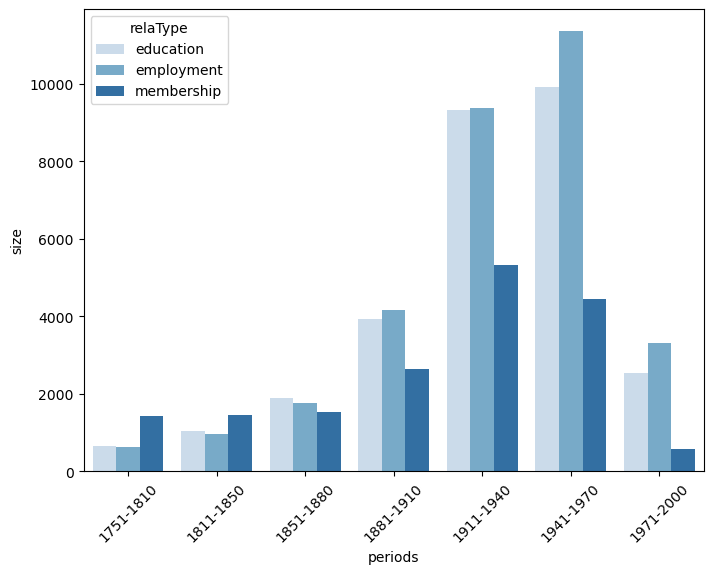

In [14]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [15]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


78224
[['academy of sciences', 'building'],
 ['comprehensive university',
  'open-access publisher',
  'organization',
  'public research university',
  'public university',
  'university of excellence'],
 ['academy of sciences', 'learned society', 'national academy']]


In [16]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,comprehensive university | open-access publish...,1911-1940,"[comprehensive university, open-access publish..."
5,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,membership,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,1,academy of sciences,1881-1910,[academy of sciences]
10,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q270222,Michigan State University,3,land-grant university | public educational ins...,1911-1940,"[land-grant university, public educational ins..."


#### Organisations' types distribution

In [17]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
university                                                                                                     2960
public university                                                                                              2420
academy of sciences                                                                                            1583
research institute                                                                                             1527
international organization | scientific organization                                                           1455
open-access publisher | public university                                                                      1432
open-access publisher | university                                                                             1401
academic publisher | learned society | nonprofit organization                                                  1321
academic publisher | academy of sciences | production company |

#### Save dataframe to CSV

In [18]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [19]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,university,2960,1
1,public university,2420,1
2,academy of sciences,1583,1
3,research institute,1527,1
4,international organization | scientific organi...,1455,2
5,open-access publisher | public university,1432,2
6,open-access publisher | university,1401,2
7,academic publisher | learned society | nonprof...,1321,3
8,academic publisher | academy of sciences | pro...,1295,4
9,academy of sciences | learned society | nation...,1152,6


In [20]:
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [21]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,membership,http://www.wikidata.org/entity/Q833738,Heidelberg Academy for Sciences and Humanities,2,academy of sciences | building,1911-1940,"[academy of sciences, building]"


In [22]:
def code_organisation_main_type(x):
    val = ''
    if 'institute of technol' in x:
        val = 'institute of technology'
    elif 'polyt' in x:
        val = 'institute of technology'    
    elif 'observato' in x:
        val = 'astronomical observatory'  
    elif 'public university' in x:
        val = 'public university'
    elif 'école normale sup' in x:
        val = 'public university'    
    elif 'grande école' in x:
        val = 'public university'
    elif 'grand établissement' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'   
    elif 'educational inst' in x:
        val = 'educational institution'    
    elif 'military academy' in x:
        val = 'educational institution' 
    elif 'naval academy' in x:
        val = 'educational institution'        
    elif 'art academy' in x:
        val = 'educational institution' 
    elif 'faculty' in x:
        val = 'university'  # could also be 'faculty'
    elif 'academic dep' in x:
        val =  'university'  # could also be 'faculty'    
    elif 'college' in x:
        val = 'educational institution'   # could also be 'college'             
    elif 'gymnas' in x:
        val = 'educational institution'   # could also be 'college'
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'research institute' in x:
        val = 'research organisation'
    elif 'max planck' in x:
        val = 'research organisation'
    elif 'institute' in x:
        val = 'research organisation' 
    elif 'research' in x:
        val = 'research organisation'
    elif 'laboratory' in x:
        val = 'research facility'  
    elif 'facility' in x:
        val = 'research facility'   
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'museum' in x:
        val = 'scientific organisation'
    elif 'nonprofit organization' in x:
        val = 'scientific organisation'    
    elif 'national academy' in x:
        val = 'scientific organisation'
    elif 'scientific organization' in x:
        val = 'scientific organisation'
    elif 'higher education' in x:
        val = 'educational institution'
    elif 'school' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academic institution' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academy' in x:
        val = 'learned society'
    elif 'society' in x:
        val = 'learned society'      
    elif 'company' in x \
                or 'business'  in x \
                or 'entrepr' in x:
        val = 'company or gov. agency' # could also be 'company'
    elif 'government' in x :
        val = 'company or gov. agency' # could also be 'government agency'         
    elif 'publish' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'     
    elif 'journal' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'
    elif 'periodical' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'    
    else:
        val = 'not classified organisation'

    return val        

In [23]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1499258,United States Naval Research Laboratory,2,military unit | research institute,1911-1940,"[military unit, research institute]",research organisation
8,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1410332,National University of Lesotho,1,public university,1911-1940,[public university],public university
9,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q649120,Argonne National Laboratory,3,laboratory | research institute | united state...,1911-1940,"[laboratory, research institute, united states...",research organisation


In [24]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
12,university,25139
8,public university,13909
0,academy of sciences,8210
5,learned society,5551
7,private university,5030
3,educational institution,4634
10,research organisation,4325
4,institute of technology,3173
11,scientific organisation,2815
6,not classified organisation,2204


In [25]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
108,academic publisher | learned society | nonprof...,learned society,1321,3
76,academic publisher | academy of sciences | pro...,academy of sciences,1295,4
174,academy of sciences | learned society | nation...,learned society,1152,6


#### 'Manual' corrections and classification improvements

In some cases, instpecting the organisations shows that the provided classification is not suitable and should be replaced:

Academia Europaea, ...

We provide this example merely to illustrate the point; further work would be required, but this is beyond the scope of this exercise.

In [26]:
### Please note the warning and the orders fo the filter, after (!) the column 
"""
Do not use:
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
"""

df_p.loc[df_p.uriOrg == 'http://www.wikidata.org/entity/Q337234', 'orgMainType'] = 'research organisation'
df_p[df_p.labelOrg.str.contains('Europaea')].head(2)



,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
121,http://www.wikidata.org/entity/Q100459,Johanna Stachel,1954,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1941-1970,"[academy, charitable organization, organization]",research organisation
292,http://www.wikidata.org/entity/Q101869,Herbert Spohn,1946,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1941-1970,"[academy, charitable organization, organization]",research organisation


# Create graphs

In [27]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     29294
employment    31537
membership    17393
dtype: int64


### Prepare the dataframe

In [28]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

78224


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [29]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
7050,http://www.wikidata.org/entity/Q6867,International Astronomical Union,international organization | scientific organi...,scientific organisation,1455
5370,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,1321
3425,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,1295
1076,http://www.wikidata.org/entity/Q123885,Royal Society,academy of sciences | learned society | nation...,learned society,1152
1347,http://www.wikidata.org/entity/Q13371,Harvard University,colonial colleges | private not-for-profit edu...,private university,905
5607,http://www.wikidata.org/entity/Q49108,Massachusetts Institute of Technology,academic publisher | institute of technology |...,institute of technology,843
2176,http://www.wikidata.org/entity/Q168756,"University of California, Berkeley",land-grant university | public educational ins...,university,696
4443,http://www.wikidata.org/entity/Q35794,University of Cambridge,collegiate university | educational organizati...,university,673
6114,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,academy of sciences | learned society | nation...,learned society,647
2979,http://www.wikidata.org/entity/Q21578,Princeton University,academic publisher | colonial colleges | priva...,private university,590


In [30]:
### Save list of organisations as CSV
csv_file='files/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [31]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
4596,http://www.wikidata.org/entity/Q193582,National Assembly,not classified organisation,1751-1810,1
6100,http://www.wikidata.org/entity/Q2720582,Royal Academy of History,learned society,1751-1810,1
4530,http://www.wikidata.org/entity/Q192088,Eton College,educational institution,1751-1810,6
3212,http://www.wikidata.org/entity/Q1573631,"Royal Military Academy, Woolwich",educational institution,1751-1810,3
12036,http://www.wikidata.org/entity/Q6858340,Mill Hill School,educational institution,1751-1810,1


In [32]:
df_orgPeriod[df_orgPeriod.labelOrg=='AMOLF']

,uriOrg,labelOrg,orgMainType,periods,period_members_number
1,http://www.wikidata.org/entity/Q1002486,AMOLF,research organisation,1941-1970,1
2,http://www.wikidata.org/entity/Q1002486,AMOLF,research organisation,1971-2000,2


#### Group by period and relationship type

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [33]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
14591,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,membership,1941-1970,879
7526,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,membership,1911-1940,517
11342,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1911-1940,507
7527,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,membership,1941-1970,339
11343,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1941-1970,319


In [34]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='files/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

236


,periods,relaType,orgMainType,period_members_number
0,1751-1810,education,astronomical observatory,2
1,1751-1810,education,educational institution,182
2,1751-1810,education,institute of technology,1
3,1751-1810,education,learned society,1
4,1751-1810,education,not classified organisation,13
5,1751-1810,education,private university,11
6,1751-1810,education,public university,197
7,1751-1810,education,research facility,15
8,1751-1810,education,scientific organisation,1
9,1751-1810,education,university,234


In [35]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

38


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [36]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [37]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [38]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,education,employment,membership,Total
orgMainType,,,,
academy of sciences,64,750,7396,8210
astronomical observatory,35,1186,11,1232
company or gov. agency,8,1105,240,1353
educational institution,3282,985,367,4634
institute of technology,1538,1634,1,3173
learned society,11,63,5014,5088
not classified organisation,205,847,1152,2204
private university,2858,2172,0,5030
public university,7036,6872,1,13909


In [39]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,education,employment,membership
orgMainType,,,
academy of sciences,64,750,7396
astronomical observatory,35,1186,11
company or gov. agency,8,1105,240
educational institution,3282,985,367
institute of technology,1538,1634,1
learned society,11,63,5014
not classified organisation,205,847,1152
private university,2858,2172,0
public university,7036,6872,1


In [40]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 71773.42 , dof : 24
p-value : 0.0
phi2 = inertie (variance totale) : 0.9175370416940659
Cramer:  0.677324531407975


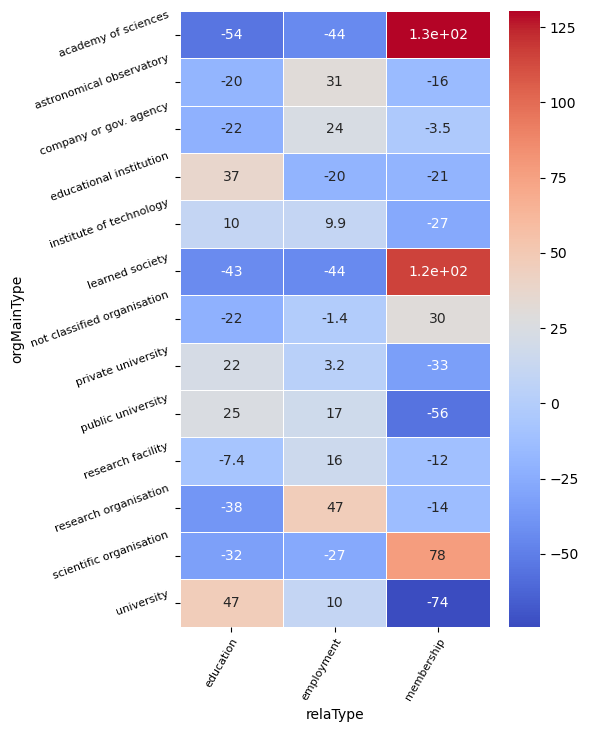

In [41]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

We observe a strong relationship between these two variables which is explained by the fact that not all organisations types are concerned by the same relationship types

We also observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [40]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer',
  39735    http://www.wikidata.org/entity/Q3511568
Name: uriPer, dtype: object),
 ('labelPer', 39735    Søren Absalon Larsen
Name: labelPer, dtype: object),
 ('birthYear', 39735    1871
Name: birthYear, dtype: int64),
 ('relaType', 39735    membership
Name: relaType, dtype: object),
 ('uriOrg',
  39735    http://www.wikidata.org/entity/Q1269766
Name: uriOrg, dtype: object),
 ('labelOrg',
  39735    Technical University of Denmark
Name: labelOrg, dtype: object)]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [41]:
### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1810,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
orgMainType,,,,,,,,
academy of sciences,847,790,778,1305,2764,1606,120,8210
astronomical observatory,30,86,145,227,250,365,129,1232
company or gov. agency,14,18,52,204,471,447,147,1353
educational institution,265,324,462,709,1449,1128,297,4634
institute of technology,22,81,138,411,906,1240,375,3173
learned society,489,505,491,845,1512,1173,73,5088
not classified organisation,106,113,186,344,642,579,234,2204
private university,24,83,217,638,1953,1744,371,5030
public university,390,540,957,1931,3813,4870,1408,13909


In [42]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [43]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 7348.78 , dof : 72
p-value : 0.0
phi2 = inertie (variance totale) : 0.09394530401585266
Cramer:  0.12513013493682798


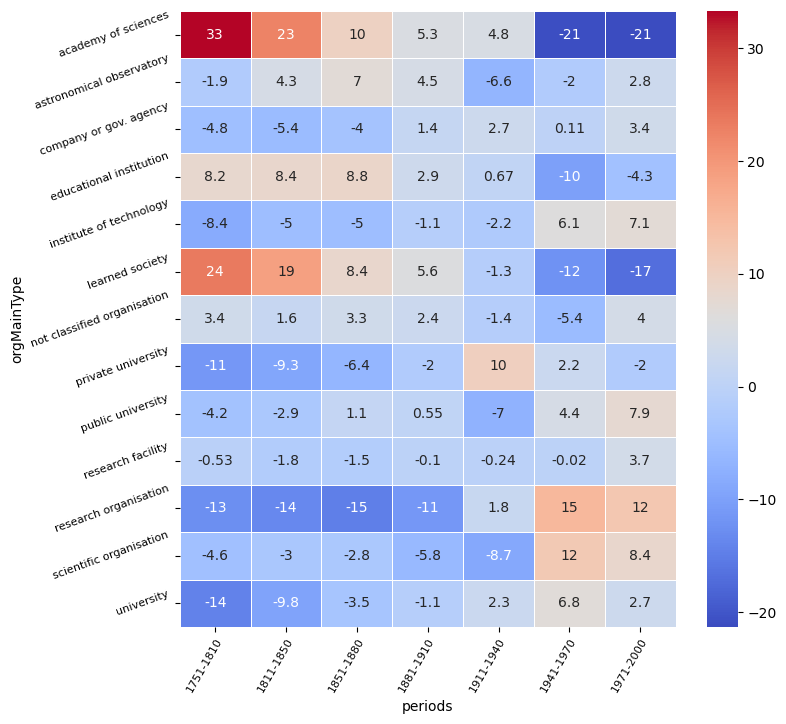

In [44]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [45]:
### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1810,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType,,,,,,,,
education,657,1037,1900,3928,9329,9906,2537,29294
employment,627,948,1758,4171,9373,11356,3304,31537
membership,1428,1460,1528,2625,5329,4450,573,17393
Total,2712,3445,5186,10724,24031,25712,6414,78224


In [46]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [47]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 3603.07 , dof : 12
p-value : 0.0
phi2 = inertie (variance totale) : 0.04606096120495781
Cramer:  0.1517579671795814


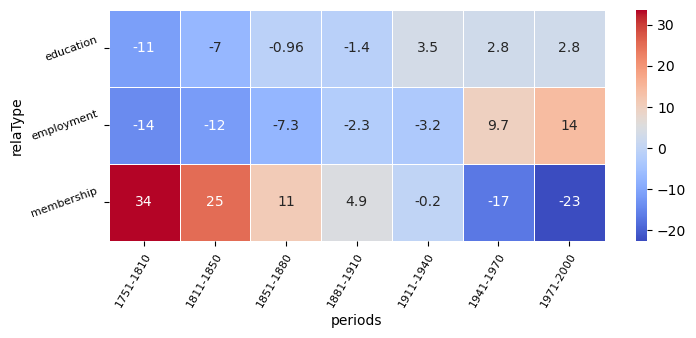

In [48]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 3))

### Explore contingency table of relationships to organisations : periods+types of relationships vs organisations types

In [49]:
df_prep['periods_relaType'] = df_prep.apply(lambda x : x.periods+'_'+x.relaType, axis=1)
df_prep.head(1)

,uriPer,labelPer,birthYear,uriOrg,labelOrg,typesOrg,orgMainType,relaType,periods,periods_relaType
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,http://www.wikidata.org/entity/Q833738,Heidelberg Academy for Sciences and Humanities,academy of sciences | building,academy of sciences,membership,1911-1940,1911-1940_membership


In [50]:
### Contingency table
X = 'periods_relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods_relaType,1751-1810_education,1751-1810_employment,1751-1810_membership,1811-1850_education,1811-1850_employment,1811-1850_membership,1851-1880_education,1851-1880_employment,1851-1880_membership,1881-1910_education,...,1911-1940_education,1911-1940_employment,1911-1940_membership,1941-1970_education,1941-1970_employment,1941-1970_membership,1971-2000_education,1971-2000_employment,1971-2000_membership,Total
orgMainType,,,,,,,,,,,,,,,,,,,,,
academy of sciences,0,11,836,0,3,787,1,13,764,1,...,18,335,2411,35,243,1328,9,52,59,8210
astronomical observatory,2,28,0,1,83,2,4,141,0,5,...,7,241,2,11,347,7,5,124,0,1232
company or gov. agency,0,7,7,0,14,4,0,35,17,1,...,2,373,96,4,374,69,1,140,6,1353
educational institution,182,77,6,239,82,3,322,134,6,481,...,1033,226,190,807,247,74,218,78,1,4634
institute of technology,1,21,0,24,57,0,61,76,1,187,...,434,472,0,647,593,0,184,191,0,3173
learned society,1,11,477,1,4,500,1,1,489,1,...,3,12,1497,3,27,1143,1,6,66,5088
not classified organisation,13,37,56,9,24,80,16,52,118,26,...,56,240,346,59,244,276,26,122,86,2204
private university,11,13,0,42,41,0,119,98,0,348,...,1145,808,0,991,753,0,202,169,0,5030
public university,197,193,0,285,255,0,473,484,0,969,...,1961,1852,0,2439,2431,0,712,696,0,13909


In [51]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [52]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 84355.56 , dof : 240
p-value : 0.0
phi2 = inertie (variance totale) : 1.0783846295153272
Cramer:  0.29977555903199304


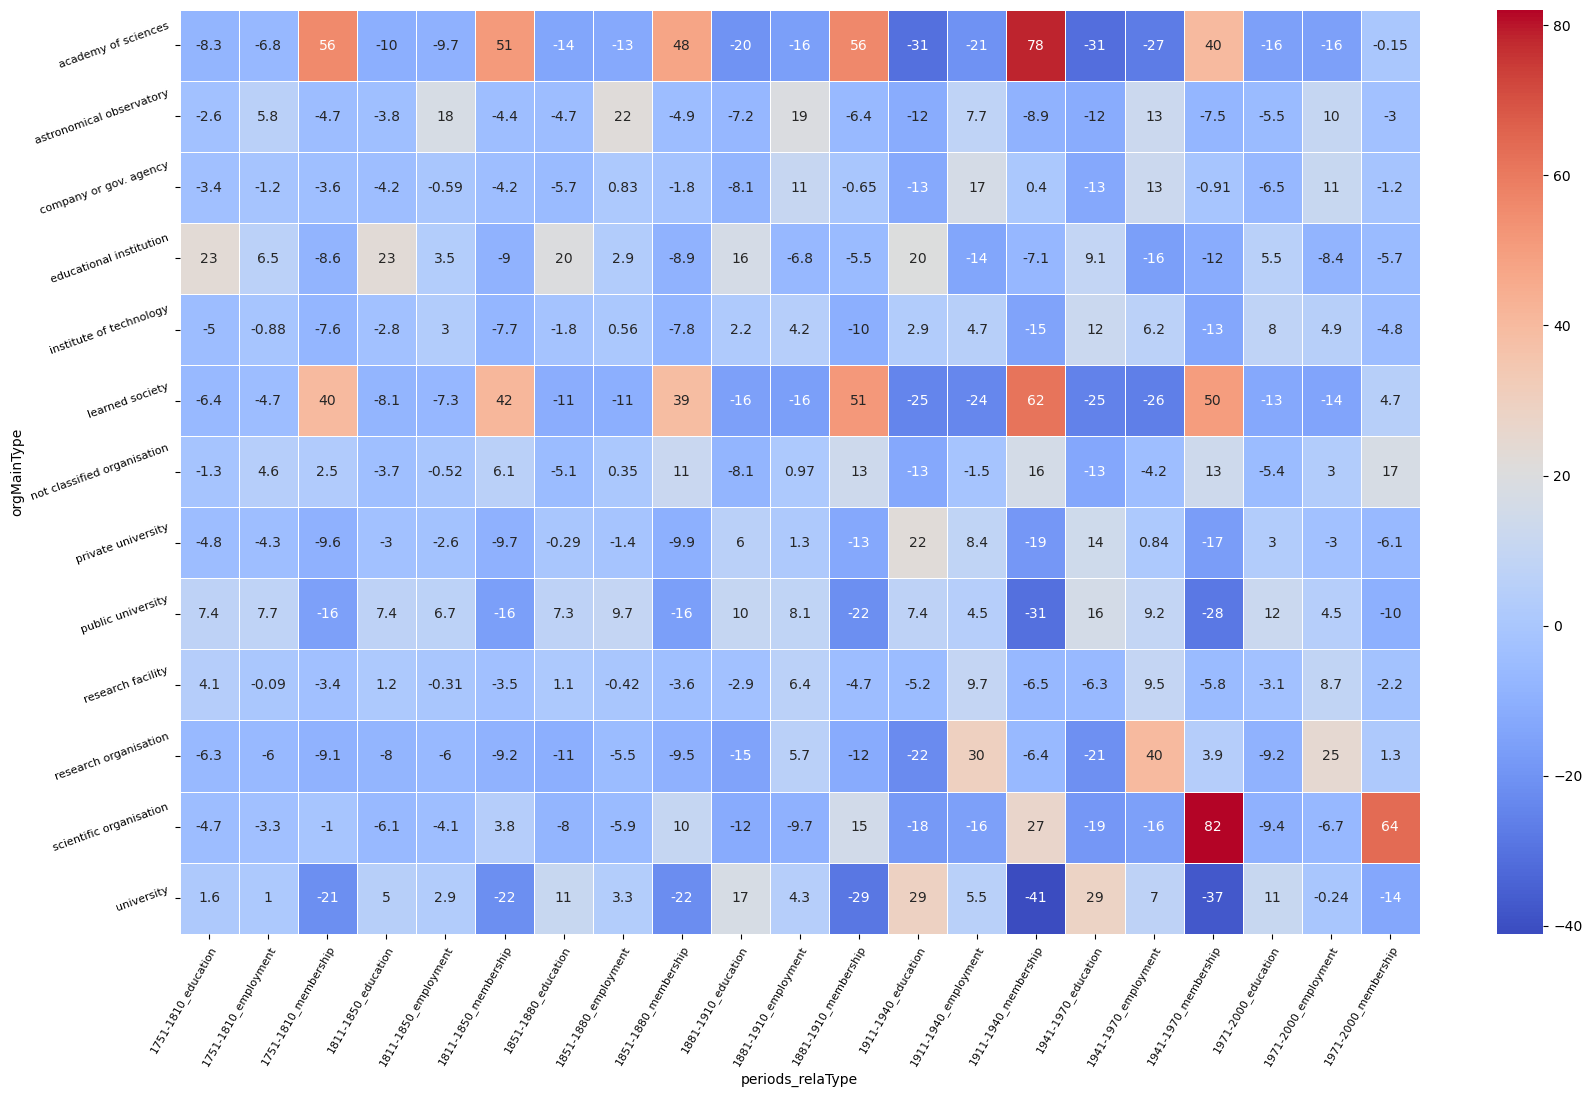

In [53]:
pp = plot_chi2_residuals(ct_wm, figsize=(20, 12))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [42]:
### Join on common organisation: Cartesian product -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


421652


In [43]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [44]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

166664
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,academy of sciences | learned society | nation...,learned society,membership,1941-1970,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,land-grant university | public educational ins...,university,education
273,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,membership
274,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,http://www.wikidata.org/entity/Q714717,Christ's College,college of the university of cambridge,university,education
275,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,http://www.wikidata.org/entity/Q466113,American Physical Society,learned society | open-access publisher | publ...,learned society,membership


In [45]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
education     29294
employment    31537
membership    17393
dtype: int64


In [46]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
8,membership,membership,25403
4,employment,employment,24786
1,education,employment,20323
3,employment,education,19878
5,employment,membership,19392
2,education,membership,16206
7,membership,employment,14150
0,education,education,13720
6,membership,education,12806


### Swap values in order to have the same orientation for all relationships

All relationships should have the same 'orientation', which is determined by alphabetical order:

education -> employment -> membership

In [47]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [48]:
### Test whether the relationship types are in the wrong alphabetical order.
condition = merged.relaType_x > merged.relaType_y

In [49]:
### Transpose under condition that the relation orientation is 'wrong',
# i.e. not according the alphabatical order

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [50]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,academy of sciences | learned society | nation...,university,education,1941-1970,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,land-grant university | public educational ins...,learned society,membership
273,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,membership
274,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q714717,Christ's College,organization,university,education,1941-1970,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,college of the university of cambridge,not classified organisation,employment
275,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,http://www.wikidata.org/entity/Q466113,American Physical Society,learned society | open-access publisher | publ...,learned society,membership
276,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,membership
277,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,http://www.wikidata.org/entity/Q217365,Bell Labs,privately held company | publisher | research ...,research organisation,employment
278,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,http://www.wikidata.org/entity/Q40358,American Association for the Advancement of Sc...,academic publisher | international organizatio...,scientific organisation,membership


In [63]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
1,education,employment,40201
4,employment,membership,33542
2,education,membership,29012
5,membership,membership,25403
3,employment,employment,24786
0,education,education,13720


In [64]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

In [65]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y,relaType_concat
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,academy of sciences | learned society | nation...,university,education,1941-1970,1941-1970_membership,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,land-grant university | public educational ins...,learned society,membership,1941-1970_education,education_membership
273,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1970,1941-1970_employment,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,membership,1941-1970_membership,employment_membership


In [66]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [67]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


115739


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
72067,1911-1940,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Michael Rossmann|Sidney Altman|Ludvig Faddeev|...,http://www.wikidata.org/entity/Q101728|http://...,364
105838,1941-1970,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Duncan Haldane|Joseph Incandela|John C. Mather...,http://www.wikidata.org/entity/Q1002250|http:/...,222
39696,1881-1910,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Peter Debye|Egon Orowan|Lars Onsager|Tjalling ...,http://www.wikidata.org/entity/Q103835|http://...,149
71880,1911-1940,membership_membership,http://www.wikidata.org/entity/Q2370801,Academy of Sciences of the USSR,academy of sciences,http://www.wikidata.org/entity/Q83172,Russian Academy of Sciences,academy of sciences,Ludvig Faddeev|Vitaly Ginzburg|Kirill Yakovlev...,http://www.wikidata.org/entity/Q1030228|http:/...,140
71058,1911-1940,membership_membership,http://www.wikidata.org/entity/Q123885,Royal Society,learned society,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Michael Rossmann|Ludvig Faddeev|Andrew Huxley|...,http://www.wikidata.org/entity/Q101728|http://...,97


### Explore contingency table of relationship pairs to periods

In [68]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1810,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType_concat,,,,,,,,
education_education,254,409,848,1755,3495,3646,1107,11514
education_employment,567,953,2092,5222,9639,11304,3685,33462
education_membership,1145,1477,1982,3315,5591,4278,675,18463
employment_employment,268,586,1287,3696,5700,7499,2691,21727
employment_membership,1119,1680,2264,4388,5911,5071,866,21299
membership_membership,952,1014,1185,1855,2463,1555,250,9274
Total,4305,6119,9658,20231,32799,33353,9274,115739


In [69]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [70]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 8814.32 , dof : 30
p-value : 0.0
phi2 = inertie (variance totale) : 0.07615684273468207
Cramer:  0.12341543074889952


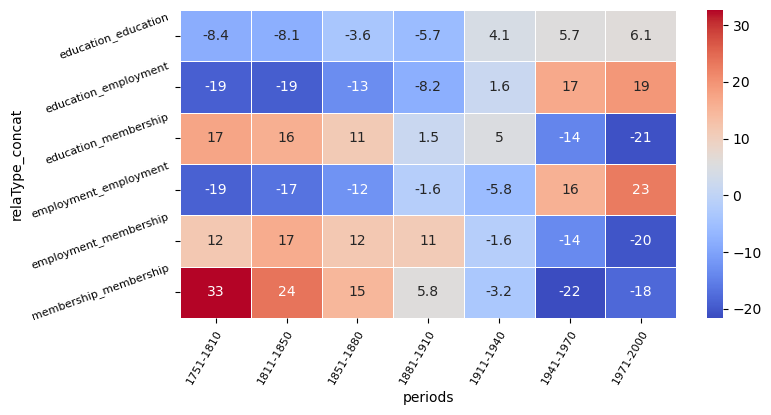

In [71]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects of the relationships:

* which organisations are connected through education, but this only at the level of universities, not earlier education stages
* in the same perspective (same kind of relations), we will explore memberships and employments, keeping them separated
* we will then ask what appears regarding the relationship between employment and membership
* we finally inspect if some kind of educational institutions (at unversity level) lead to specific employments or memberships.






### Organisations connected through higher education

In [74]:
pprint.pprint(sorted(df_mainTypes.mainType.to_list()))

['academy of sciences',
 'astronomical observatory',
 'company or gov. agency',
 'educational institution',
 'institute of technology',
 'learned society',
 'not classified organisation',
 'private university',
 'public university',
 'research facility',
 'research organisation',
 'scientific organisation',
 'university']


In [75]:
types_list=['university', 'public university', 'private university']

In [76]:
df_edu_graph = df_graph[(df_graph.relaType_concat == 'education_education') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_edu_graph))
df_edu_graph.iloc[:2]

5833


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
8,1751-1810,education_education,http://www.wikidata.org/entity/Q106947038,Q106947038,university,http://www.wikidata.org/entity/Q3064332,Science Faculty of Paris,university,Mikhail Ostrogradsky,http://www.wikidata.org/entity/Q355892,1
21,1751-1810,education_education,http://www.wikidata.org/entity/Q1189954,Mines ParisTech,public university,http://www.wikidata.org/entity/Q209842,University of Paris,university,Angelo Sismonda,http://www.wikidata.org/entity/Q3617232,1


In [77]:
df_edu_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
40961,1911-1940,education_education,http://www.wikidata.org/entity/Q13164,Moscow State University,public university,http://www.wikidata.org/entity/Q2367144,MSU Faculty of Physics,university,Vitaly Ginzburg|Lev Altshuler|Q15073626|Anatol...,http://www.wikidata.org/entity/Q104668|http://...,27
40960,1911-1940,education_education,http://www.wikidata.org/entity/Q13164,Moscow State University,public university,http://www.wikidata.org/entity/Q2367115,MSU Faculty of Mechanics and Mathematics,university,Valentin Esipov|Gary Gavrilov|Vladimir Arnold|...,http://www.wikidata.org/entity/Q112133335|http...,23


In [78]:
### Number of relationships by period
print(df_edu_graph.groupby('periods').size())

periods
1751-1810      93
1811-1850     161
1851-1880     389
1881-1910     870
1911-1940    1757
1941-1970    1960
1971-2000     603
dtype: int64


### Inspect a specific period

In [80]:
p = '1881-1910' #'1851-1880' #'1911-1940'

In [81]:
df_edu_graph_p = df_edu_graph[(df_edu_graph.periods==p)]
df_edu_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
21482,1881-1910,education_education,http://www.wikidata.org/entity/Q332342,Trinity College,university,http://www.wikidata.org/entity/Q35794,University of Cambridge,university,William Lawrence Bragg|William McCrea|Subrahma...,http://www.wikidata.org/entity/Q131729|http://...,12
20703,1881-1910,education_education,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilian-University in Munich,public university,Dimitrios Chondros|Werner Uhink|Wilhelm Heinri...,http://www.wikidata.org/entity/Q12876062|http:...,10


In [82]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      ## the weight ist the number of persons in this relationship
      'weight':e['number']}
     )) 
     for e in df_edu_graph_p.to_dict(orient='records')]
print(len(l))

870


In [83]:
edu_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
edu_graph_p.add_edges_from(l)

naf.basic_graph_properties(edu_graph_p)

### Create a list of graphs, one per component
edu_graph_p_S = [edu_graph_p.subgraph(c).copy() for c in nx.connected_components(edu_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(edu_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 412,
 'number_of_edges': 870,
 '------': '------',
 'is connected': False,
 'components': 14,
 'density': 0.010275671461980015}
[[0, 384], [3, 3], [5, 3], [1, 2], [2, 2]]


In [84]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Just one big component


In [85]:
### Alternative way with just one graph
pG = edu_graph_p_S[0]
naf.basic_graph_properties(pG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 384,
 'number_of_edges': 854,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.011613359442993907}


In [86]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
12046,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,1941-1970,883
6083,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,1911-1940,518


In [87]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
0,http://www.wikidata.org/entity/Q100148173,Samaldas Arts College,educational institution,1
7,http://www.wikidata.org/entity/Q1003730,Bulgarian Academy of Sciences,academy of sciences,10
10,http://www.wikidata.org/entity/Q1004412,Bulletin of the Atomic Scientists,company or gov. agency,1
19,http://www.wikidata.org/entity/Q1007545,Galatasaray High School,educational institution,1
37,http://www.wikidata.org/entity/Q1010477,International Time Bureau,not classified organisation,1


In [88]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q102398072',
  {'label': 'philosophy faculty of the German university of Prague',
   'mainType': 'university',
   'membersNumber': 6}),
 ('http://www.wikidata.org/entity/Q102398197',
  {'label': 'Faculty of Law, German University in Prague',
   'mainType': 'university',
   'membersNumber': 1})]


In [89]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
print(mn_s.groupby(by=mn_s).size().sort_values(ascending=False))

university            244
public university     109
private university     31
dtype: int64


####  Create dataframe and inspect node properties

In [90]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

[('http://www.wikidata.org/entity/Q102398072',
  {'eigenvector': 0.015222917458227885,
   'label': 'philosophy faculty of the German university of Prague',
   'mainType': 'university',
   'membersNumber': 6})]


In [91]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


[('http://www.wikidata.org/entity/Q102398072',
  {'betweenness': 0.006216690377060662,
   'eigenvector': 0.015222917458227885,
   'label': 'philosophy faculty of the German university of Prague',
   'mainType': 'university',
   'membersNumber': 6})]


In [92]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,membersNumber,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q102398072,philosophy faculty of the German university of...,university,6,0.015223,0.006217
1,http://www.wikidata.org/entity/Q102398197,"Faculty of Law, German University in Prague",university,1,0.000524,0.0


In [93]:
df_mainTypes

,mainType,number
12,university,25139
8,public university,13909
0,academy of sciences,8210
5,learned society,5551
7,private university,5030
3,educational institution,4634
10,research organisation,4325
4,institute of technology,3173
11,scientific organisation,2815
6,not classified organisation,2204


In [ ]:
### exclude less relevant or dirty classifications
lt=[t for t in df_mainTypes.mainType.to_list()
                if ('educat' not in t)  & ('classif' not in t)]
pprint.pprint(lt)

['university',
 'public university',
 'academy of sciences',
 'learned society',
 'private university',
 'research organisation',
 'institute of technology',
 'scientific organisation',
 'company or gov. agency',
 'astronomical observatory',
 'research facility']


In [95]:
### source
# https://phrogz.net/css/distinct-colors.html
col_l = [c.strip() for c in '#ff0066, #0000ff, #00aaff,#beb6f2, #b6e6f2, #e6f2b6, #f2b6b6,#2d50b3, #ccff00, #8c005e, #8c8300'.split(',')]
print(col_l)

['#ff0066', '#0000ff', '#00aaff', '#beb6f2', '#b6e6f2', '#e6f2b6', '#f2b6b6', '#2d50b3', '#ccff00', '#8c005e', '#8c8300']


In [96]:
col_list= [e for e in zip(lt, col_l)]
print(col_list)

[('university', '#ff0066'), ('public university', '#0000ff'), ('academy of sciences', '#00aaff'), ('learned society', '#beb6f2'), ('private university', '#b6e6f2'), ('research organisation', '#e6f2b6'), ('institute of technology', '#f2b6b6'), ('scientific organisation', '#2d50b3'), ('company or gov. agency', '#ccff00'), ('astronomical observatory', '#8c005e'), ('research facility', '#8c8300')]


In [97]:
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'academy of sciences': '#00aaff',
 'astronomical observatory': '#8c005e',
 'company or gov. agency': '#ccff00',
 'institute of technology': '#f2b6b6',
 'learned society': '#beb6f2',
 'private university': '#b6e6f2',
 'public university': '#0000ff',
 'research facility': '#8c8300',
 'research organisation': '#e6f2b6',
 'scientific organisation': '#2d50b3',
 'university': '#ff0066'}


In [129]:
### Manually modified list
color_map = {'academy of sciences': '#00aaff',
 'astronomical observatory': '#8c005e',
 'company or gov. agency': '#ccff00',
 'institute of technology': '#f2b6b6',
 'learned society': '#ff0066',
 'private university': '#ffcc00',
 'public university': '#8c8300',
 'research facility': '#d90000',
 'research organisation': '#beb6f2',
 'scientific organisation': '#2d50b3',
 'university': '#b6e6f2'}

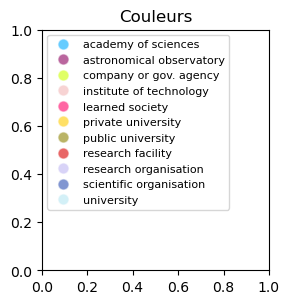

In [130]:

fig = plt.figure(figsize=(3,3))


### Create lists of colors and labels
colors = [color_map.keys()]
 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=0.6
                            ) for label, color in color_map.items() ],
                            loc='upper left', fontsize=8)
plt.tight_layout() # rect=[0,0,0.8,1]

plt.title('Couleurs')

plt.show()

In [131]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.97]).item()
    test_v2 = df[value_2].quantile([0.95]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items() 
                                    if label in types_list ],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.09375758199857782 0.0312820771041274


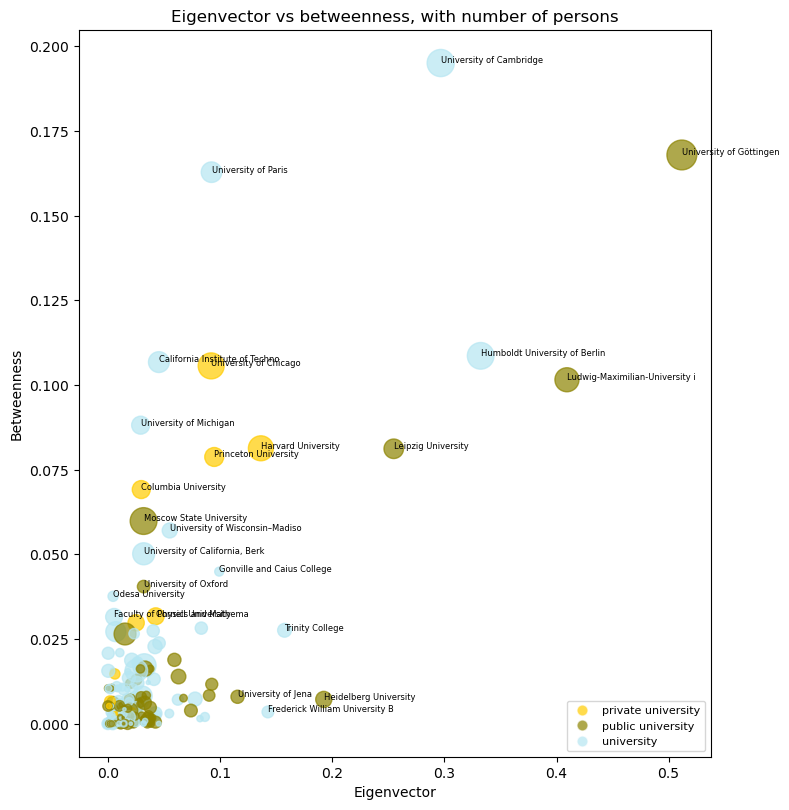

Spearman's rank correlation: 0.645765533624037


In [132]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(8,8), 
                          legend_loc='lower right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [ ]:
list(nodes_df.columns)

In [102]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness
                                      label            mainType membersNumber
23                  University of Cambridge          university           128
27                  University of Göttingen   public university           154
43                      University of Paris          university            73
78            Humboldt University of Berlin          university           123
109      California Institute of Technology          university            75
12                    University of Chicago  private university           117
4    Ludwig-Maximilian-University in Munich   public university           100

-----
Eigenvector
                                      label           mainType membersNumber
27                  University of Göttingen  public university           154
4    Ludwig-Maximilian-University in Munich  public university           100
78            Humboldt University of Berlin         university           123
23                  University of Cam

#### Plot graph

In [107]:
pict_addr = 'images/organisations/edu_edu_' + p +'.svg'
print(pict_addr)

images/organisations/edu_edu_1881-1910.svg


In [133]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=12, alpha=alpha_n
                        )
                        for label, color in color_map.items()
                        if label in types_list ],
                        loc='lower right', fontsize=12)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


### Communitites

In [ ]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


In [ ]:
for i in range(0,5):
   print('\n\nCommunity '+ str(i), '\nBetweenness')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))
   print('\n-----\nEigenvector')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))


#### Plot communitites graph

In [ ]:
pict_addr_comm = 'images/organisations/edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

In [ ]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


## Create general function

In [ ]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = 'images/organisations/' + concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [ ]:
print(df_mainTypes.mainType.to_list())

In [ ]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

In [ ]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

In [ ]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)